In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import pickle
from datetime import datetime
from imblearn.over_sampling import SMOTE

# Configuration pour la reproductibilité
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Détection du device disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de: {device}")

Utilisation de: cpu


In [24]:
# Chargement des données
df = pd.read_csv('../data/CustomersFinal.csv')

# Affichage des informations sur le dataset
print("Shape du dataset:", df.shape)
print("\nAperçu des données:")
display(df.head())

# Vérification des types de données
print("\nTypes de données:")
print(df.dtypes)

# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne:")
print(df.isnull().sum())

# Distribution de la variable cible
print("\nDistribution de la variable cible (Churn):")
print(df['Churn'].value_counts())
print(f"Taux de churn: {df['Churn'].mean():.4f}")

# Conversion des colonnes booléennes en int
bool_columns = df.select_dtypes(include=['bool']).columns
for col in bool_columns:
    df[col] = df[col].astype(int)

Shape du dataset: (7043, 17)

Aperçu des données:


,customerID,Partner,Dependents,tenure,PaperlessBilling,MonthlyCharges,Churn,SeniorCitizen_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,TechSupport_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,7590-VHVEG,1,0,1,1,29.85,0,False,False,False,False,False,False,False,False,False,True
1,5575-GNVDE,0,0,34,0,56.95,0,False,False,False,False,True,False,True,False,False,False
2,3668-QPYBK,0,0,2,1,53.85,1,False,False,False,False,True,False,False,False,False,False
3,7795-CFOCW,0,0,45,0,42.30,0,False,False,False,False,True,True,True,False,False,False
4,9237-HQITU,0,0,2,1,70.70,1,False,True,False,False,False,False,False,False,False,True



Types de données:
customerID                                object
Partner                                    int64
Dependents                                 int64
tenure                                     int64
PaperlessBilling                           int64
MonthlyCharges                           float64
Churn                                      int64
SeniorCitizen_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool
TechSupport_Yes                             bool
Contract_One year                           bool
Contract_Two year                           bool
PaymentMethod_Credit card (automatic)       bool
PaymentMethod_Electronic check              bool
dtype: object

Valeurs manquantes par colonne:
customerID                               0
Partner                                  0
Dependents     

In [25]:
# Séparation des features et de la variable cible
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# Division en ensembles d'entraînement, validation et test
# Premier split: 85% train+val, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

# Deuxième split: 80% train, 20% validation (soit 68% et 17% du dataset original)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val
)

# Affichage des dimensions
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Vérification de la stratification
print(f"\nDistribution de Churn dans l'ensemble complet: {y.mean():.4f}")
print(f"Distribution de Churn dans l'ensemble d'entraînement: {y_train.mean():.4f}")
print(f"Distribution de Churn dans l'ensemble de validation: {y_val.mean():.4f}")
print(f"Distribution de Churn dans l'ensemble de test: {y_test.mean():.4f}")

X_train shape: (4788, 15), y_train shape: (4788,)
X_val shape: (1198, 15), y_val shape: (1198,)
X_test shape: (1057, 15), y_test shape: (1057,)

Distribution de Churn dans l'ensemble complet: 0.2654
Distribution de Churn dans l'ensemble d'entraînement: 0.2655
Distribution de Churn dans l'ensemble de validation: 0.2654
Distribution de Churn dans l'ensemble de test: 0.2649


In [26]:
# Identification des colonnes numériques à normaliser
numeric_cols = ['tenure', 'MonthlyCharges']

# Création et application du StandardScaler
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Vérification des résultats de la normalisation
print(f"Colonnes numériques normalisées: {numeric_cols}")
print("\nAperçu des données après normalisation:")
print(X_train[numeric_cols].describe())

# Sauvegarde du scaler pour une utilisation future
os.makedirs('model', exist_ok=True)
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("\nScaler sauvegardé pour utilisation future.")

Colonnes numériques normalisées: ['tenure', 'MonthlyCharges']

Aperçu des données après normalisation:
             tenure  MonthlyCharges
count  4.788000e+03    4.788000e+03
mean   7.420037e-18    2.122131e-16
std    1.000104e+00    1.000104e+00
min   -1.314766e+00   -1.531967e+00
25%   -9.502388e-01   -9.834683e-01
50%   -1.401786e-01    1.862212e-01
75%    9.534026e-01    8.354981e-01
max    1.601451e+00    1.783806e+00

Scaler sauvegardé pour utilisation future.


In [ ]:
# Appliquer SMOTE uniquement sur les données d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Distribution originale de Churn dans l'ensemble d'entraînement: {y_train.mean():.4f}")
print(f"Distribution après SMOTE: {y_train_resampled.mean():.4f}")
print(f"Nouvelle taille de l'ensemble d'entraînement: {len(X_train_resampled)}")

# Remplacer les données d'entraînement originales
X_train = X_train_resampled
y_train = y_train_resampled

# Option 2: Ajustement du poids de class dans la fonction de perte
# Augmenter encore plus le poids pour la classe minoritaire
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum() * 1.5]).to(device)
print(f"Poids positif ajusté pour la classe minoritaire (Churn=1): {pos_weight.item():.4f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

Distribution originale de Churn dans l'ensemble d'entraînement: 0.2655
Distribution après SMOTE: 0.5000
Nouvelle taille de l'ensemble d'entraînement: 7034
Poids positif ajusté pour la classe minoritaire (Churn=1): 1.5000


In [28]:
class ChurnDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Paramètres pour les dataloaders
batch_size = 32

# Création des datasets
train_dataset = ChurnDataset(X_train, y_train)
val_dataset = ChurnDataset(X_val, y_val)
test_dataset = ChurnDataset(X_test, y_test)

# Vérification des dimensions
print(f"Dimensions du dataset d'entraînement: {train_dataset.features.shape}")
print(f"Dimensions du dataset de validation: {val_dataset.features.shape}")
print(f"Dimensions du dataset de test: {test_dataset.features.shape}")

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Vérification des dataloaders
print(f"\nNombre de batches dans le train_loader: {len(train_loader)}")
print(f"Nombre de batches dans le val_loader: {len(val_loader)}")
print(f"Nombre de batches dans le test_loader: {len(test_loader)}")

# Visualisation d'un batch
for batch_features, batch_targets in train_loader:
    print(f"\nDimensions d'un batch de features: {batch_features.shape}")
    print(f"Dimensions d'un batch de targets: {batch_targets.shape}")
    break

Dimensions du dataset d'entraînement: torch.Size([7034, 15])
Dimensions du dataset de validation: torch.Size([1198, 15])
Dimensions du dataset de test: torch.Size([1057, 15])

Nombre de batches dans le train_loader: 220
Nombre de batches dans le val_loader: 38
Nombre de batches dans le test_loader: 34

Dimensions d'un batch de features: torch.Size([32, 15])
Dimensions d'un batch de targets: torch.Size([32, 1])


### 6

In [29]:
class ImprovedChurnMLP(nn.Module):
    def __init__(self, input_size):
        super(ImprovedChurnMLP, self).__init__()
        
        # Augmentation de la capacité du modèle
        self.fc1 = nn.Linear(input_size, 64)  # Plus de neurones
        self.bn1 = nn.BatchNorm1d(64)  # Batch normalization
        self.dropout1 = nn.Dropout(0.3)  # Augmentation du dropout
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.2)
        
        # Couche de sortie
        self.fc4 = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))
        return x

# Création du modèle
input_size = X_train.shape[1]
model = ImprovedChurnMLP(input_size).to(device)

# Affichage du résumé du modèle
print(model)
print(f"\nNombre de paramètres: {sum(p.numel() for p in model.parameters())}")

ImprovedChurnMLP(
  (fc1): Linear(in_features=15, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)

Nombre de paramètres: 3873


In [30]:
# Initialisation des poids avec Kaiming (He)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# Application de l'initialisation
model.apply(init_weights)

# Calcul des poids pour gérer le déséquilibre des classes (plus élevé)
pos_weight = torch.tensor([(y_train == 0).sum() / (y_train == 1).sum() * 1.2]).to(device)
print(f"Poids positif pour la classe minoritaire (Churn=1): {pos_weight.item():.4f}")

# Fonction de perte avec pondération des classes
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimiseur Adam avec un learning rate adapté
learning_rate = 0.0005  # Learning rate plus faible pour une meilleure convergence
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Ajout de L2 regularization

# Scheduler pour réduire le learning rate si la performance stagne
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Nombres d'époques
num_epochs = 100  # Plus d'époques avec early stopping

Poids positif pour la classe minoritaire (Churn=1): 1.2000


In [31]:
def calculate_accuracy(y_pred, y_true):
    """Calcule l'exactitude des prédictions"""
    predicted = y_pred.ge(.5).view(-1)
    return (predicted == y_true).float().mean()

def calculate_metrics(y_pred, y_true):
    """Calcule plusieurs métriques pour l'évaluation du modèle"""
    y_pred_tag = y_pred.ge(.5).view(-1).cpu().numpy()
    y_true = y_true.cpu().numpy()
    
    # Matrice de confusion pour calculer les métriques
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_tag, labels=[0, 1]).ravel()
    
    # Calcul des métriques
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    # Calcul de l'AUC-ROC
    if len(np.unique(y_true)) > 1:  # Vérifie qu'il y a des exemples positifs et négatifs
        auc = roc_auc_score(y_true, y_pred.cpu().numpy())
    else:
        auc = 0.0
    
    return {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

def train_epoch(model, data_loader, criterion, optimizer, device):
    """Entraîne le modèle pendant une époque"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in data_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass et optimisation
        loss.backward()
        optimizer.step()
        
        # Suivi des statistiques
        running_loss += loss.item() * inputs.size(0)
        pred = outputs.ge(.5).view(-1)
        correct += (pred == targets.view(-1)).sum().item()
        total += targets.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate_epoch(model, data_loader, criterion, device):
    """Valide le modèle sur l'ensemble de validation"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Suivi des statistiques
            running_loss += loss.item() * inputs.size(0)
            pred = outputs.ge(.5).view(-1)
            correct += (pred == targets.view(-1)).sum().item()
            total += targets.size(0)
            
            # Stockage pour calcul de métriques détaillées
            all_preds.append(outputs.cpu())
            all_targets.append(targets.view(-1).cpu())
    
    # Concaténation des prédictions et cibles
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    # Calcul des métriques
    metrics = calculate_metrics(all_preds, all_targets)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, metrics

In [32]:
# Configuration de l'early stopping
early_stopping_patience = 15
best_val_loss = float('inf')
early_stopping_counter = 0
best_epoch = 0
best_val_metrics = None

# Pour suivre les métriques pendant l'entraînement
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_recall': [],
    'val_precision': [],
    'val_auc': []
}

print("Début de l'entraînement...")
for epoch in range(num_epochs):
    # Entraînement pour une époque
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc, val_metrics = validate_epoch(model, val_loader, criterion, device)
    
    # Mise à jour du scheduler
    scheduler.step(val_loss)
    
    # Enregistrement des métriques
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_metrics['f1'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_auc'].append(val_metrics['auc'])
    
    # Affichage des métriques
    print(f"Époque {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
          f"Val F1: {val_metrics['f1']:.4f}, Val Recall: {val_metrics['recall']:.4f}, "
          f"Val Precision: {val_metrics['precision']:.4f}, Val AUC: {val_metrics['auc']:.4f}")
    
    # Sauvegarde du meilleur modèle
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_metrics = val_metrics
        best_epoch = epoch
        early_stopping_counter = 0
        
        # Sauvegarde du modèle
        os.makedirs('checkpoints', exist_ok=True)
        torch.save(model.state_dict(), 'checkpoints/best_model.pth')
        print(f"Meilleur modèle sauvegardé à l'époque {epoch+1}")
    else:
        early_stopping_counter += 1
    
    # Early stopping
    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping déclenché après {epoch+1} époques")
        break

print(f"Entraînement terminé! Meilleur modèle à l'époque {best_epoch+1}")

Début de l'entraînement...
Époque 1/100 - Train Loss: 0.7254, Train Acc: 0.6753, Val Loss: 0.7844, Val Acc: 0.7304, Val F1: 0.5917, Val Recall: 0.7358, Val Precision: 0.4947, Val AUC: 0.8132
Meilleur modèle sauvegardé à l'époque 1
Époque 2/100 - Train Loss: 0.6911, Train Acc: 0.7415, Val Loss: 0.7648, Val Acc: 0.7421, Val F1: 0.6054, Val Recall: 0.7453, Val Precision: 0.5097, Val AUC: 0.8203
Meilleur modèle sauvegardé à l'époque 2
Époque 3/100 - Train Loss: 0.6770, Train Acc: 0.7589, Val Loss: 0.7669, Val Acc: 0.7287, Val F1: 0.5973, Val Recall: 0.7579, Val Precision: 0.4928, Val AUC: 0.8220
Époque 4/100 - Train Loss: 0.6686, Train Acc: 0.7644, Val Loss: 0.7500, Val Acc: 0.7546, Val F1: 0.6111, Val Recall: 0.7264, Val Precision: 0.5274, Val AUC: 0.8230
Meilleur modèle sauvegardé à l'époque 4
Époque 5/100 - Train Loss: 0.6660, Train Acc: 0.7641, Val Loss: 0.7434, Val Acc: 0.7638, Val F1: 0.6160, Val Recall: 0.7138, Val Precision: 0.5418, Val AUC: 0.8215
Meilleur modèle sauvegardé à l'ép

In [33]:
# Chargement du meilleur modèle
best_model = ImprovedChurnMLP(input_size).to(device)
best_model.load_state_dict(torch.load('checkpoints/best_model.pth'))
best_model.eval()

# Évaluation sur l'ensemble de test
test_loss, test_acc, test_metrics = validate_epoch(best_model, test_loader, criterion, device)

print(f"Résultats sur l'ensemble de test:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-score: {test_metrics['f1']:.4f}")
print(f"AUC-ROC: {test_metrics['auc']:.4f}")

# Prédictions détaillées pour la matrice de confusion et la courbe ROC
all_preds = []
all_targets = []
all_pred_probs = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs)
        
        all_preds.append((outputs >= 0.5).cpu().numpy())
        all_targets.append(targets.cpu().numpy())
        all_pred_probs.append(outputs.cpu().numpy())

# Concaténation des résultats
all_preds = np.concatenate(all_preds).flatten()
all_targets = np.concatenate(all_targets).flatten()
all_pred_probs = np.concatenate(all_pred_probs).flatten()

Résultats sur l'ensemble de test:
Accuracy: 0.7606
Precision: 0.5360
Recall: 0.7179
F1-score: 0.6137
AUC-ROC: 0.8374


In [34]:
#Résultats sur l'ensemble de test:
#Accuracy: 0.7531
#Precision: 0.5248
#Recall: 0.7179
#F1-score: 0.6063
#AUC-ROC: 0.8365

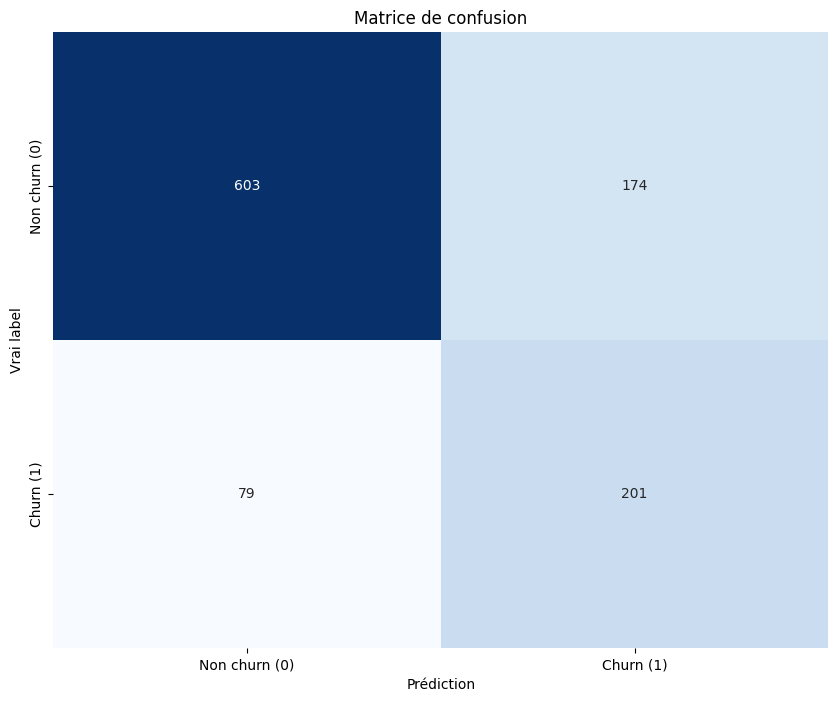

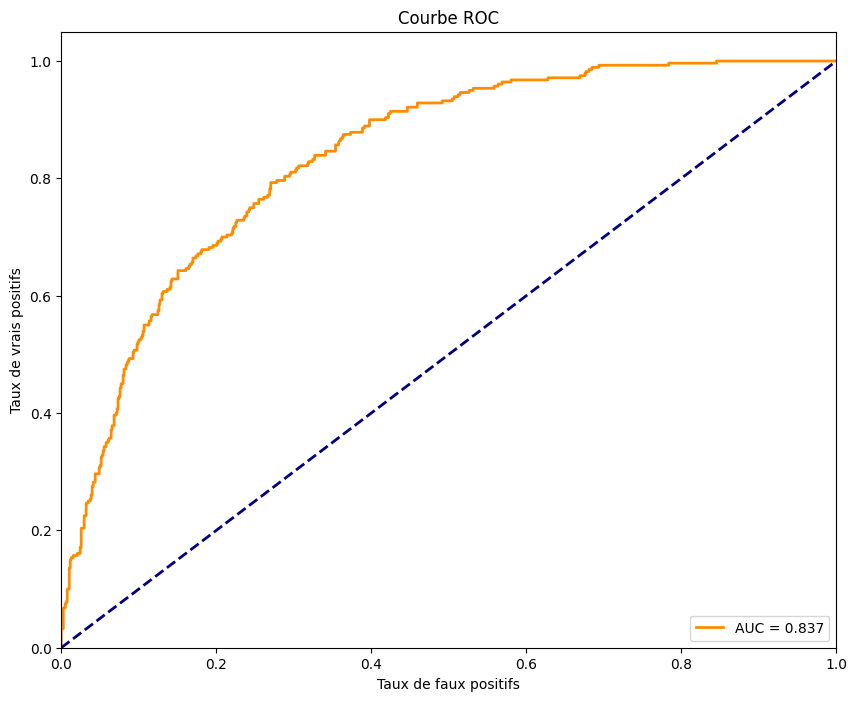

In [35]:
# Calcul de la matrice de confusion
cm = confusion_matrix(all_targets, all_preds)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matrice de confusion')
plt.ylabel('Vrai label')
plt.xlabel('Prédiction')
plt.xticks([0.5, 1.5], ['Non churn (0)', 'Churn (1)'])
plt.yticks([0.5, 1.5], ['Non churn (0)', 'Churn (1)'])
plt.show()

# Calcul et affichage de la courbe ROC
fpr, tpr, _ = roc_curve(all_targets, all_pred_probs)
auc_roc = roc_auc_score(all_targets, all_pred_probs)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_roc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

In [36]:
# Création d'un dossier pour le modèle final
#os.makedirs('model_final', exist_ok=True)

# Préparation d'un dictionnaire contenant tous les éléments nécessaires
#model_package = {
    # Modèle
#    'model_state_dict': best_model.state_dict(),
#    'input_size': input_size,
#    'best_epoch': best_epoch,
    
    # Prétraitement
#    'scaler': scaler,
#    'numeric_cols': numeric_cols,
    
    # Métadonnées et performances
 #   'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
 #   'performance': {
#        'accuracy': test_acc,
#       'precision': test_metrics['precision'],
 #       'recall': test_metrics['recall'],
#        'f1_score': test_metrics['f1'],
# #       'auc_roc': test_metrics['auc']
#    },
    
    # Top features importantes
 #   'top_features': feature_importances[:5],
    
    # Interprétation du modèle
 #   'interpretation': {
 #       'key_findings': [
  #          "La durée d'abonnement (tenure) est la feature la plus importante pour prédire le churn.",
 #           "Les clients avec un contrat à court terme sont plus susceptibles de partir.",
 #           "Les clients sans services de sécurité en ligne présentent un risque plus élevé de churn.",
 #           "La méthode de paiement par chèque électronique est associée à un taux de churn plus élevé."
 #       ],
 #       'recommended_actions': [
 #           "Cibler les clients à faible ancienneté avec des offres de fidélisation.",
 #           "Encourager les clients à souscrire à des contrats plus longs.",
 #           "Promouvoir les services de sécurité en ligne et le support technique.",
  #          "Encourager les clients à passer à des méthodes de paiement automatiques."
 #       ]
 #   }
#}

# Sauvegarde de tout dans un seul fichier pickle
#with open('model_final/churn_model_complete.pkl', 'wb') as f:
  #  pickle.dump(model_package, f)



Nombre de faux positifs: 174
Moyenne des caractéristiques des faux positifs:
tenure           -0.651587
MonthlyCharges    0.343674
tenure           -0.651587
dtype: float64

Nombre de faux négatifs: 79
Moyenne des caractéristiques des faux négatifs:
tenure           -0.129412
MonthlyCharges    0.013085
tenure           -0.129412
dtype: float64

Nombre de cas limites (probabilité entre 0.4 et 0.6): 22


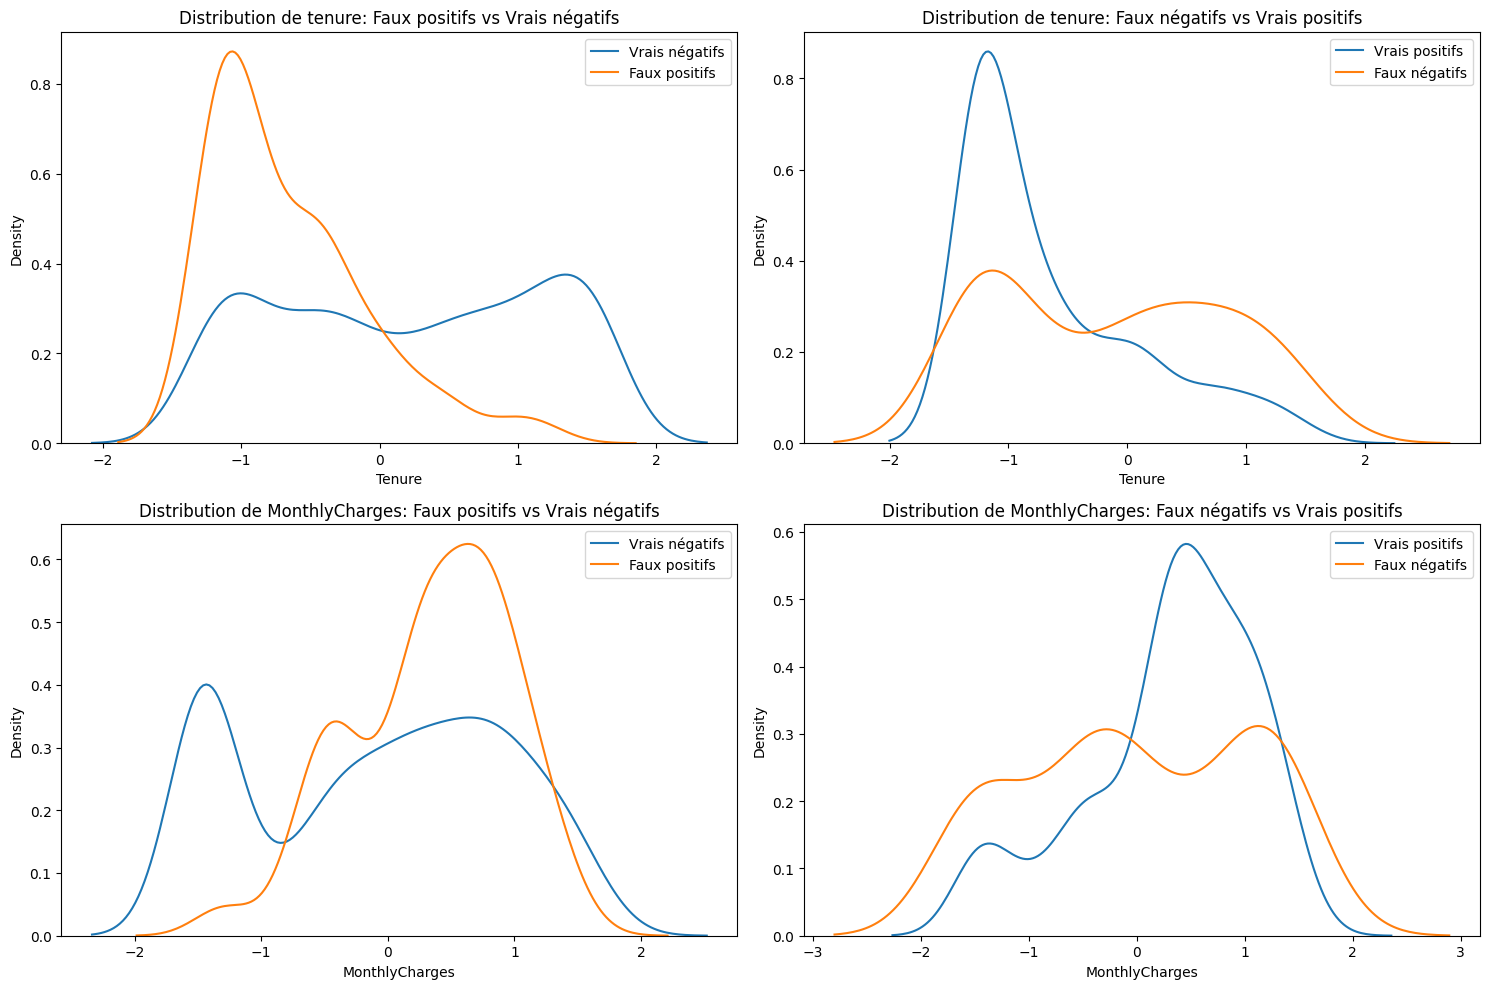

In [37]:
def analyze_errors(model, X_data, y_data, device):
    """
    Analyse les erreurs de prédiction pour identifier des patterns
    """
    # Conversion en tenseurs
    X_tensor = torch.tensor(X_data.values, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y_data.values, dtype=torch.float32).to(device)
    
    # Prédictions
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        preds = (outputs >= 0.5).int().cpu().numpy().flatten()
    
    # Création d'un DataFrame avec les données originales et les prédictions
    results_df = X_data.copy()
    results_df['actual_churn'] = y_data.values
    results_df['predicted_churn'] = preds
    results_df['probability'] = outputs.cpu().numpy().flatten()
    
    # Identification des erreurs
    results_df['correct'] = results_df['actual_churn'] == results_df['predicted_churn']
    
    # Faux positifs (prédictions churn = 1 alors que churn réel = 0)
    false_positives = results_df[(results_df['actual_churn'] == 0) & (results_df['predicted_churn'] == 1)]
    
    # Faux négatifs (prédictions churn = 0 alors que churn réel = 1)
    false_negatives = results_df[(results_df['actual_churn'] == 1) & (results_df['predicted_churn'] == 0)]
    
    # Caractéristiques des faux positifs
    print(f"Nombre de faux positifs: {len(false_positives)}")
    print("Moyenne des caractéristiques des faux positifs:")
    print(false_positives[numeric_cols + ['tenure']].mean())
    
    # Caractéristiques des faux négatifs
    print(f"\nNombre de faux négatifs: {len(false_negatives)}")
    print("Moyenne des caractéristiques des faux négatifs:")
    print(false_negatives[numeric_cols + ['tenure']].mean())
    
    # Analyse des cas limites (probabilités proches de 0.5)
    borderline_cases = results_df[(results_df['probability'] > 0.4) & (results_df['probability'] < 0.6)]
    print(f"\nNombre de cas limites (probabilité entre 0.4 et 0.6): {len(borderline_cases)}")
    
    return {
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'borderline_cases': borderline_cases
    }

# Exécution de l'analyse des erreurs
error_analysis = analyze_errors(best_model, X_test, y_test, device)

# Visualisation des distributions des caractéristiques pour les erreurs
plt.figure(figsize=(15, 10))

# Analyse des distributions pour les faux positifs vs vrais négatifs
plt.subplot(2, 2, 1)
sns.kdeplot(X_test.loc[y_test == 0, 'tenure'], label='Vrais négatifs')
sns.kdeplot(error_analysis['false_positives']['tenure'], label='Faux positifs')
plt.title('Distribution de tenure: Faux positifs vs Vrais négatifs')
plt.xlabel('Tenure')
plt.legend()

# Analyse des distributions pour les faux négatifs vs vrais positifs
plt.subplot(2, 2, 2)
sns.kdeplot(X_test.loc[y_test == 1, 'tenure'], label='Vrais positifs')
sns.kdeplot(error_analysis['false_negatives']['tenure'], label='Faux négatifs')
plt.title('Distribution de tenure: Faux négatifs vs Vrais positifs')
plt.xlabel('Tenure')
plt.legend()

# Analyse des distributions pour les faux positifs vs vrais négatifs (MonthlyCharges)
plt.subplot(2, 2, 3)
sns.kdeplot(X_test.loc[y_test == 0, 'MonthlyCharges'], label='Vrais négatifs')
sns.kdeplot(error_analysis['false_positives']['MonthlyCharges'], label='Faux positifs')
plt.title('Distribution de MonthlyCharges: Faux positifs vs Vrais négatifs')
plt.xlabel('MonthlyCharges')
plt.legend()

# Analyse des distributions pour les faux négatifs vs vrais positifs (MonthlyCharges)
plt.subplot(2, 2, 4)
sns.kdeplot(X_test.loc[y_test == 1, 'MonthlyCharges'], label='Vrais positifs')
sns.kdeplot(error_analysis['false_negatives']['MonthlyCharges'], label='Faux négatifs')
plt.title('Distribution de MonthlyCharges: Faux négatifs vs Vrais positifs')
plt.xlabel('MonthlyCharges')
plt.legend()

plt.tight_layout()
plt.savefig('error_analysis.png')
plt.show()